In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv("C:\\Users\\cauld\\Downloads\\corona_tested_individuals_ver_00167.csv")
# df.reset_index(drop=True, inplace=True)

C:\Users\cauld\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
profile = ProfileReport(df.sample(n=600000).reset_index(drop=True), title='Pandas Profiling Report')
profile

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import numpy as np
import lightgbm as lgb

In [12]:
train_data = lgb.Dataset('train.svm.bin')

In [13]:
data = np.random.rand(500, 10)  # 500 entities, each contains 10 features
label = np.random.randint(2, size=500)  # binary target
train_data = lgb.Dataset(data, label=label)

In [17]:
import scipy
csr = scipy.sparse.csr_matrix((data, (row, col)))
train_data = lgb.Dataset(csr)

NameError: name 'row' is not defined

In [14]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [15]:
num_round = 10
bst = lgb.train(param, train_data, num_round)

[LightGBM] [Info] Number of positive: 249, number of negative: 251
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498000 -> initscore=-0.008000
[LightGBM] [Info] Start training from score -0.008000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Number of positive: 259777, number of negative: 3576963
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 3836740, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067708 -> initscore=-2.622446
[LightGBM] [Info] Start training from score -2.622446
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[265]	valid_0's auc: 0.897603
Accuracy on Data:  0.9384884362826585 

AUC score:  0.8965566420121902


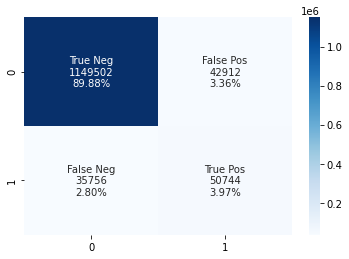

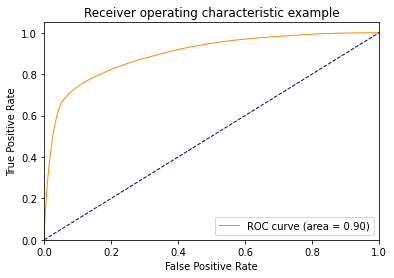

In [19]:
import numpy as np
import pandas as pd
import seaborn as sn
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def get_clean_data(cur):

    '''
      parameters:
        cur: snowflake execution instance

      returns:
        data: cleaned data
    '''

    # cur.execute("SELECT * from COVID_SYMP_TEST_CLEAN")

    # putting all data into a pandas dataframe
    # data = pd.DataFrame(cur.fetchall(), columns=['TEST_DATE', 'COUGH', 'FEVER', 'SORE_THROAT',
    #                     'SHORTNESS_OF_BREATH', 'HEAD_ACHE', 'CORONA_RESULT', 'AGE_60_AND_ABOVE', 'GENDER', 'TEST_INDICATION'])
    data = pd.read_csv('result.csv')

    # normalising the parameter test_date
    data['TEST_DATE'] = MinMaxScaler().fit_transform(
        np.array(data['TEST_DATE']).reshape(-1, 1))

    return data


def get_train_test_validation(data):

    '''
      parameters:
        data: cleaned data from get_clean_data function

      returns:
        ret_info: dictionary
          train: tuple of features and labels as pandas dataframe
          test: tuple of features and labels as pandas dataframe
          validation: tuple of features and labels as pandas dataframe
    '''

    X = data.drop(['CORONA_RESULT'], axis=1)
    Y = data['CORONA_RESULT']

    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, test_size=0.4, random_state=42)
    X_test, X_validation, Y_test, Y_validation = train_test_split(
        X_temp, Y_temp, test_size=0.5, random_state=42)

    ret_info = {
        'train': (X_train, Y_train),
        'test': (X_test, Y_test),
        'validation': (X_validation, Y_validation)
    }

    return ret_info


def train_model(X, Y, X_validation, Y_validation):

    '''
      parameters:
        X: training data
        Y: labels corresponding to training data
        X_validation: validation data
        Y_validation: labels corresponding to validation data

      returns:
        model: trained model ready for prediction
    '''

    train_data = lgb.Dataset(X, label=Y)
    validation_data = lgb.Dataset(X_validation, label=Y_validation)

    num_round = 500
    param = {'num_leaves': 70, 'objective': 'binary',
             'metric': 'auc', 'learning_rate': 0.05}

    model = lgb.train(param, train_data, num_round,
                      early_stopping_rounds=5, valid_sets=[validation_data], verbose_eval=-1)

    return model


def plot_roc_curve(Y, pred):

    '''
    parameters:
      Y: label
      pred: model output
    '''

    print('AUC score: ', roc_auc_score(Y, pred))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(Y, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 1
    plt.plot(fpr[1], tpr[1], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


def predict(model, X, Y):

    '''
    parameters:
      model: trained model from train_model function
      X: input data for prediction
      Y: true labels for input data
    '''

    pred = model.predict(X)
    Y_pred = np.array(list(map(lambda x: 1 if x >= 0.33 else 0, pred)))

    print('Accuracy on Data: ', accuracy_score(Y, Y_pred), '\n')

    cf_matrix = confusion_matrix(Y, Y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    plot_roc_curve(Y, pred)
    # plot_precision_recall_curve(Y, pred)
    plt.show()


def run(cur):

    '''
      parameters:
       cur: snowflake connection instance

      Runs all the functions sequentially
    '''

    # cleaned and normalised data
    data = get_clean_data(cur)

    # dictionary containing splitted data
    splitted_data = get_train_test_validation(data)

    X_train, Y_train = splitted_data['train']
    X_test, Y_test = splitted_data['test']
    X_validation, Y_validation = splitted_data['validation']

    # trained model ready for prediction
    model = train_model(X_train, Y_train, X_validation, Y_validation)

    # making predictions and plots on test_data
    predict(model, X_test, Y_test)

    ret_info = {
        'model': model,
        'splitted_data': splitted_data,
    }

    return model, X_test.columns


model, columns = run(None)

# Accuracy on Data:  0.9384884362826585 


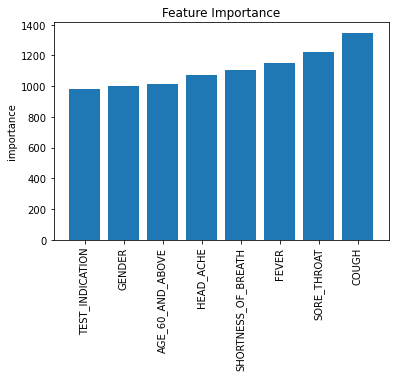

In [41]:

def feature_importance(model, columns):

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance()[1:], columns[1:])), columns=['Value','Feature'])
#     print(feature_imp)
    
    plt.bar(feature_imp.Feature, feature_imp.Value)
    plt.xticks(rotation=90)

    plt.title('Feature Importance')
    plt.ylabel('importance')
    plt.show()

feature_importance(model, columns)